In [14]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from io import StringIO
import numpy as np

# Function to scrape data from FBRef
def scrape_fbref_data(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = soup.prettify().replace('<!--', '').replace('-->', '')
    df_list = pd.read_html(StringIO(html_content))
    df = df_list[-1]
    df.columns = df.columns.droplevel(0)
    return df[df['Player'] != 'Player']

# Function to rename duplicate columns
def rename_duplicate_columns(df, suffix):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols + suffix
    return df

# Function to create full stats database
def create_full_stats_db():
    urls = {
        'passing': 'https://fbref.com/en/comps/22/passing/Major-League-Soccer-Stats',
        'shooting': 'https://fbref.com/en/comps/22/shooting/Major-League-Soccer-Stats',
        'passing_type': 'https://fbref.com/en/comps/22/passing_types/Major-League-Soccer-Stats',
        'defense': 'https://fbref.com/en/comps/22/defense/Major-League-Soccer-Stats',
        'gca': 'https://fbref.com/en/comps/22/gca/Major-League-Soccer-Stats',
        'possession': 'https://fbref.com/en/comps/22/possession/Major-League-Soccer-Stats',
        'misc': 'https://fbref.com/en/comps/22/misc/Major-League-Soccer-Stats'
    }
    
    data_frames = {name: rename_duplicate_columns(scrape_fbref_data(url), f"_{name}") for name, url in urls.items()}
    
    index_df = data_frames['misc'][['Player_misc', 'Nation_misc', 'Pos_misc', 'Squad_misc', 'Age_misc', 'Born_misc', '90s_misc']]
    for name, df in data_frames.items():
        df.drop(columns=[col for col in df.columns if col.startswith('Matches') or col.startswith('Rk')], inplace=True, errors='ignore')
        df.dropna(axis=0, how='any', inplace=True)
        index_df = pd.merge(index_df, df, left_on=['Player_misc', 'Nation_misc', 'Pos_misc', 'Squad_misc', 'Age_misc', 'Born_misc', '90s_misc'],
                            right_on=[f'Player_{name}', f'Nation_{name}', f'Pos_{name}', f'Squad_{name}', f'Age_{name}', f'Born_{name}', f'90s_{name}'], how='left')
    
    index_df.fillna(0, inplace=True)
    return index_df

# Create the full stats database
full_stats_db = create_full_stats_db()

# Print the columns and first few rows of the full stats database
print("Columns of the full stats database:")
print(full_stats_db.columns)
print("\nFirst few rows of the full stats database:")
print(full_stats_db.head())


Columns of the full stats database:
Index(['Player_misc', 'Nation_misc', 'Pos_misc', 'Squad_misc', 'Age_misc',
       'Born_misc', '90s_misc', 'Player_passing', 'Nation_passing',
       'Pos_passing',
       ...
       'Crs_misc', 'Int_misc', 'TklW_misc', 'PKwon_misc', 'PKcon_misc',
       'OG_misc', 'Recov_misc', 'Won_misc', 'Lost_misc', 'Won%_misc'],
      dtype='object', length=174)

First few rows of the full stats database:
            Player_misc Nation_misc Pos_misc   Squad_misc Age_misc Born_misc  \
0            Liel Abada      il ISR       FW    Charlotte   22-236      2001   
1  Jose Casas de Abadal      us USA    FW,DF  Inter Miami   23-341      2000   
2            Luis Abram      pe PER       DF  Atlanta Utd   28-089      1996   
3        Lalas Abubakar      gh GHA    DF,MF       Rapids   29-153      1994   
4         Kellyn Acosta      us USA       MF         Fire   28-307      1995   

  90s_misc        Player_passing Nation_passing Pos_passing  ... Crs_misc  \
0      4.

In [15]:
# Function to classify players into specific positions
def position_grouping(x):
    keepers = ['GK']
    defenders = ["DF", 'DF,MF']
    wing_backs = ['FW,DF', 'DF,FW']
    defensive_mids = ['MF,DF']
    midfielders = ['MF']
    attacking_mids = ['MF,FW', "FW,MF"]
    forwards = ['FW']
    if x in keepers:
        return "GK"
    elif x in defenders:
        return "Defender"
    elif x in wing_backs:
        return "Wing-Back"
    elif x in defensive_mids:
        return "Defensive-Midfielders"
    elif x in midfielders:
        return "Central Midfielders"
    elif x in attacking_mids:
        return "Attacking Midfielders"
    elif x in forwards:
        return "Forwards"
    else:
        return "Unidentified Position"

# Function to normalize stats per 90 minutes played
def per_90fi(dataframe):
    dataframe = dataframe.replace('', np.nan)
    dataframe = dataframe.fillna(0)
    exclude_columns = ['Player_misc', 'Nation_misc', 'Pos_misc', 'Squad_misc', 'Age_misc', 'Born_misc', 'position_group']
    numeric_columns = [col for col in dataframe.columns if np.issubdtype(dataframe[col].dtype, np.number) 
                       and col != '90s_misc' and not any(exc_col in col for exc_col in exclude_columns)
                       and ('90' not in col) and ('%' not in col)]
    mask = (dataframe['90s_misc'] != 0)
    dataframe.loc[mask, numeric_columns] = dataframe.loc[mask, numeric_columns].div(dataframe.loc[mask, '90s_misc'], axis=0)
    return dataframe

# Apply position grouping to the full stats database
full_stats_db['position_group'] = full_stats_db['Pos_misc'].apply(position_grouping)

# Normalize statistics per 90 minutes
full_stats_db = per_90fi(full_stats_db)

# Print the columns and first few rows of the updated database
print("Columns of the updated full stats database:")
print(full_stats_db.columns)
print("\nFirst few rows of the updated full stats database:")
print(full_stats_db.head())


Columns of the updated full stats database:
Index(['Player_misc', 'Nation_misc', 'Pos_misc', 'Squad_misc', 'Age_misc',
       'Born_misc', '90s_misc', 'Player_passing', 'Nation_passing',
       'Pos_passing',
       ...
       'Int_misc', 'TklW_misc', 'PKwon_misc', 'PKcon_misc', 'OG_misc',
       'Recov_misc', 'Won_misc', 'Lost_misc', 'Won%_misc', 'position_group'],
      dtype='object', length=175)

First few rows of the updated full stats database:
            Player_misc Nation_misc Pos_misc   Squad_misc Age_misc Born_misc  \
0            Liel Abada      il ISR       FW    Charlotte   22-236      2001   
1  Jose Casas de Abadal      us USA    FW,DF  Inter Miami   23-341      2000   
2            Luis Abram      pe PER       DF  Atlanta Utd   28-089      1996   
3        Lalas Abubakar      gh GHA    DF,MF       Rapids   29-153      1994   
4         Kellyn Acosta      us USA       MF         Fire   28-307      1995   

  90s_misc        Player_passing Nation_passing Pos_passing  ...

In [19]:
# Define key performance indicators for each position based on available columns
def key_stats_db(df, position):
    non_numeric_cols = ['Player_misc', 'Nation_misc', 'Pos_misc', 'Squad_misc', 'Age_misc', 'position_group']
    core_stats = {
        'GK': ['90s_misc', 'TklW_misc', 'Recov_misc'],
        'Defender': ['90s_misc', 'Tkl_defense', 'Int_defense', 'Blocks_defense', 'Clr_defense', 'Tkl+Int_defense'],
        'Wing-Back': ['90s_misc', 'Tkl_defense', 'Int_defense', 'Cmp%_passing', 'KP_passing', 'CrsPA_passing'],
        'Defensive-Midfielders': ['90s_misc', 'Tkl_defense', 'Int_defense', 'Cmp%_passing', 'KP_passing', 'PPA_passing', 'PrgP_passing'],
        'Central Midfielders': ['90s_misc', 'Tkl_defense', 'Int_defense', 'Cmp%_passing', 'KP_passing', 'PPA_passing', 'PrgP_passing', 'PrgC_possession'],
        'Attacking Midfielders': ['90s_misc', 'SCA90_gca', 'GCA90_gca', 'xA_passing', 'PrgP_passing', 'PrgC_possession', 'KP_passing'],
        'Forwards': ['90s_misc', 'Gls_shooting', 'Sh_shooting', 'SoT_shooting', 'xG_shooting', 'npxG_shooting', 'SCA90_gca', 'GCA90_gca']
    }

    if position in core_stats:
        key_stats = core_stats[position]
        key_stats_df = df[df['position_group'] == position]
        key_stats_df = key_stats_df[non_numeric_cols + key_stats]
        key_stats_df = key_stats_df[pd.to_numeric(key_stats_df['90s_misc'], errors='coerce') > 5]
        key_stats_df = per_90fi(key_stats_df)
        return key_stats_df
    else:
        print(f"Position {position} not recognized.")
        return pd.DataFrame()

# Extract key statistics for each position
positions = ['GK', 'Defender', 'Wing-Back', 'Defensive-Midfielders', 'Central Midfielders', 'Attacking Midfielders', 'Forwards']
key_stats = {position: key_stats_db(full_stats_db, position) for position in positions}

# Print key statistics for each position
for position, stats_df in key_stats.items():
    print(f"Key statistics for {position}:")
    print(stats_df.head())
    print("\n")


Key statistics for GK:
           Player_misc Nation_misc Pos_misc     Squad_misc Age_misc  \
88           Alex Bono      us USA       GK    D.C. United   30-031   
97   Christopher Brady      us USA       GK           Fire   20-084   
110        Roman Bürki      ch SUI       GK      St. Louis   33-194   
117    Drake Callender      us USA       GK    Inter Miami   26-232   
129    Roman Celentano      us USA       GK  FC Cincinnati   23-255   

    position_group 90s_misc TklW_misc Recov_misc  
88              GK     15.0         0         29  
97              GK     14.0         0          9  
110             GK     14.0         0         20  
117             GK     15.0         1         18  
129             GK     11.0         0         10  


Key statistics for Defender:
         Player_misc Nation_misc Pos_misc      Squad_misc Age_misc  \
2         Luis Abram      pe PER       DF     Atlanta Utd   28-089   
15      Carlos Akapo      gq EQG       DF  SJ Earthquakes   31-075   
18 

In [22]:
def rank_players(df, key_stats):
    # Convert relevant columns to numeric and handle non-numeric values
    for col in key_stats:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Calculate the mean of key stats for ranking
    df['Rank'] = df[key_stats].mean(axis=1)
    return df.sort_values('Rank', ascending=False)

# Define key stats for ranking
key_stats_columns = {
    'GK': ['TklW_misc', 'Recov_misc'],
    'Defender': ['Tkl_defense', 'Int_defense', 'Blocks_defense', 'Clr_defense', 'Tkl+Int_defense'],
    'Wing-Back': ['Tkl_defense', 'Int_defense', 'Cmp%_passing', 'KP_passing', 'CrsPA_passing'],
    'Defensive-Midfielders': ['Tkl_defense', 'Int_defense', 'Cmp%_passing', 'KP_passing', 'PPA_passing', 'PrgP_passing'],
    'Central Midfielders': ['Tkl_defense', 'Int_defense', 'Cmp%_passing', 'KP_passing', 'PPA_passing', 'PrgP_passing', 'PrgC_possession'],
    'Attacking Midfielders': ['SCA90_gca', 'GCA90_gca', 'xA_passing', 'PrgP_passing', 'PrgC_possession', 'KP_passing'],
    'Forwards': ['Gls_shooting', 'Sh_shooting', 'SoT_shooting', 'xG_shooting', 'npxG_shooting', 'SCA90_gca', 'GCA90_gca']
}

# Extract key statistics for each position
positions = ['GK', 'Defender', 'Wing-Back', 'Defensive-Midfielders', 'Central Midfielders', 'Attacking Midfielders', 'Forwards']
key_stats = {position: key_stats_db(full_stats_db, position) for position in positions}

# Rank players and select top performers for each position
top_players = {}
for position, stats_df in key_stats.items():
    key_stats = key_stats_columns[position]
    ranked_df = rank_players(stats_df, key_stats)
    top_players[position] = ranked_df.head(5)  # Select top 5 players for each position

# Print top players for each position
for position, players_df in top_players.items():
    print(f"Top players for {position}:")
    print(players_df[['Player_misc', 'Squad_misc', 'Rank'] + key_stats_columns[position]])
    print("\n")


Top players for GK:
           Player_misc   Squad_misc  Rank  TklW_misc  Recov_misc
574       Zack Steffen       Rapids  15.5          0          31
88           Alex Bono  D.C. United  14.5          0          29
455       Maarten Paes    FC Dallas  14.0          0          28
387          Tim Melia  Sporting KC  13.5          0          27
306  Kristijan Kahlina    Charlotte  12.0          0          24


Top players for Defender:
       Player_misc      Squad_misc  Rank  Tkl_defense  Int_defense  \
148    Vitor Costa  SJ Earthquakes  36.8           44           13   
50     Julián Aude       LA Galaxy  35.2           33           20   
273  Aaron Herrera     D.C. United  34.4           33           20   
638  Joel Waterman     CF Montréal  34.0           14           29   
510      Rodrigues  SJ Earthquakes  33.6           26           19   

     Blocks_defense  Clr_defense  Tkl+Int_defense  
148              15           55               57  
50               25           45     

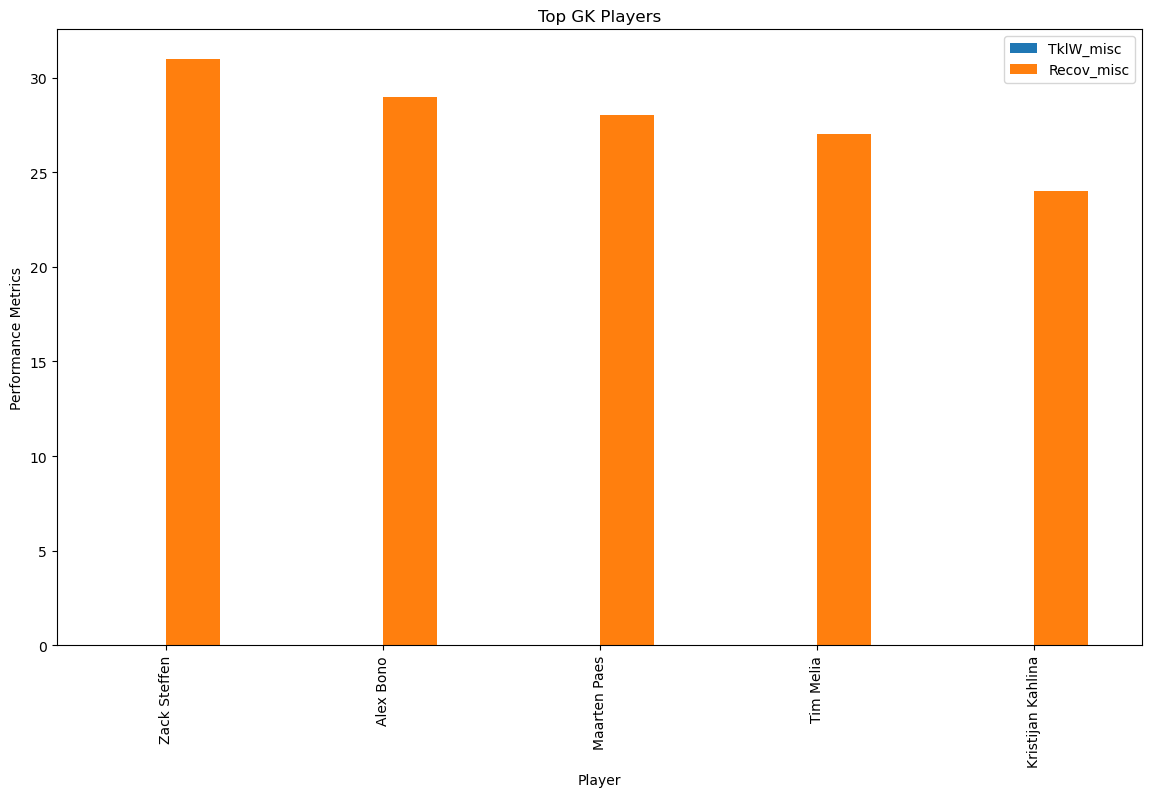

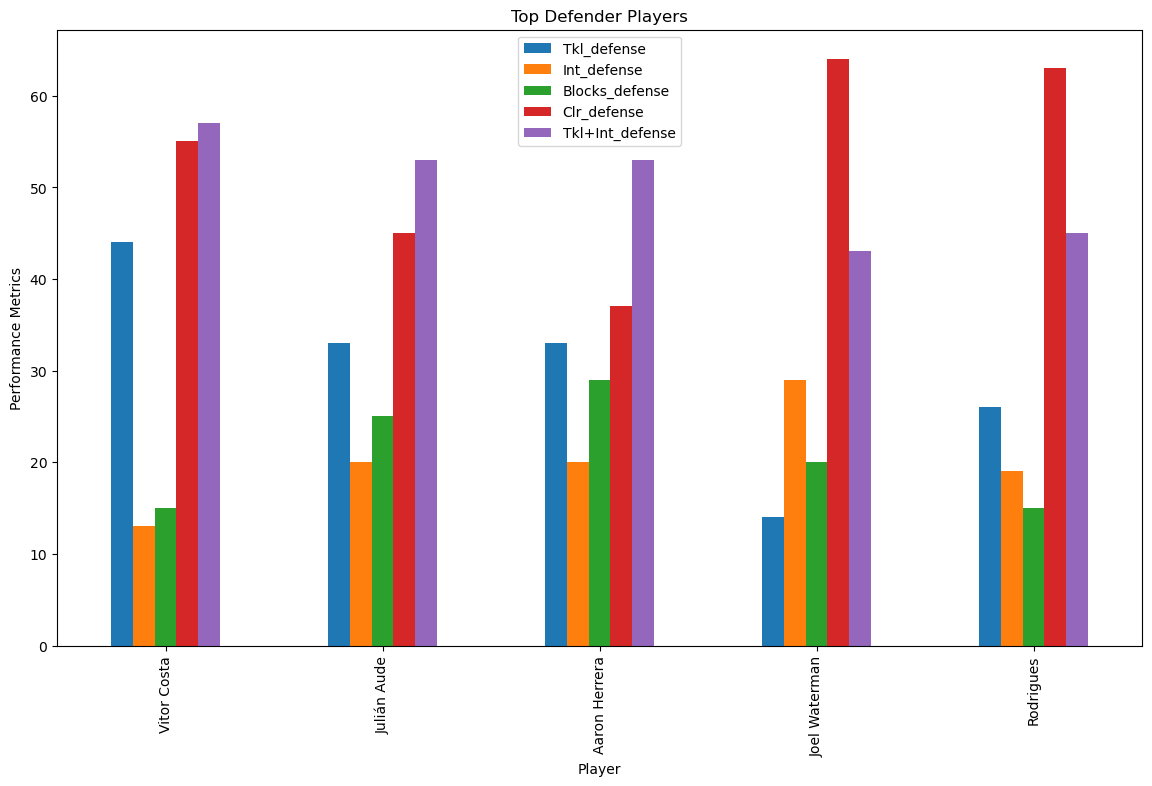

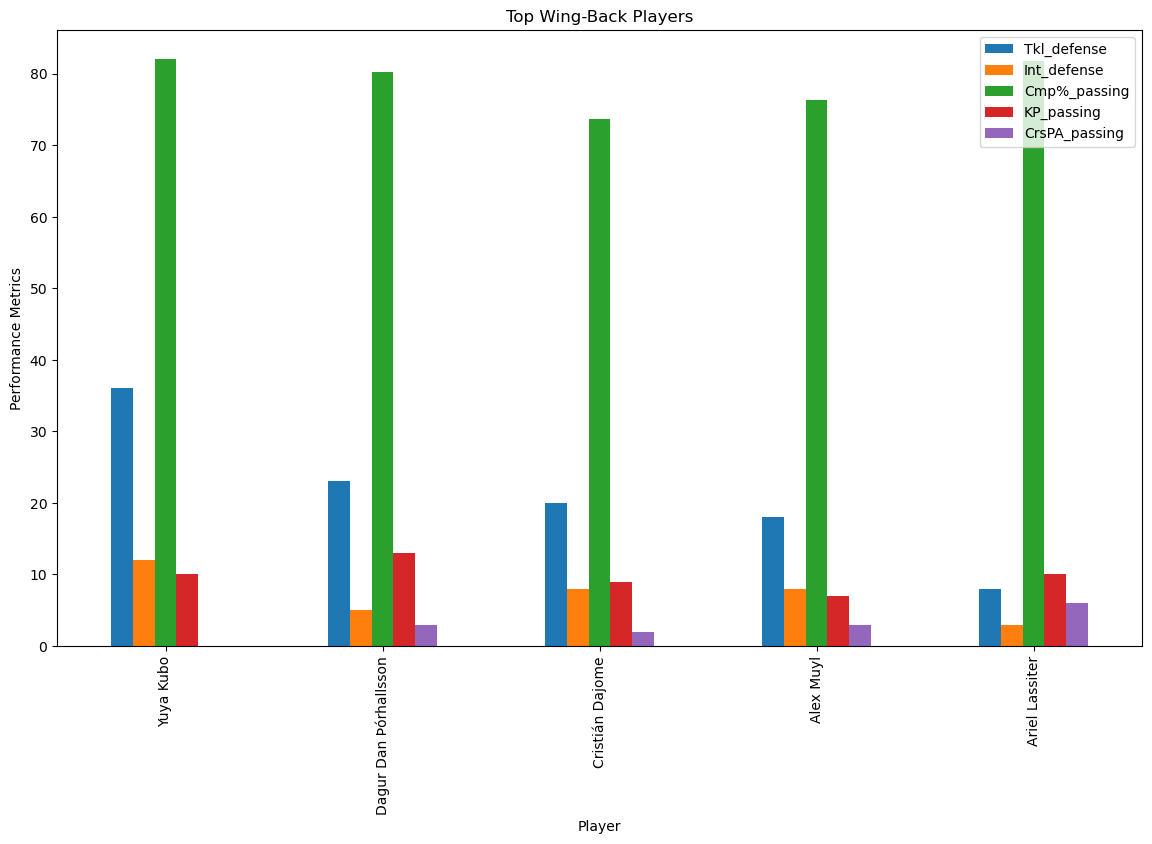

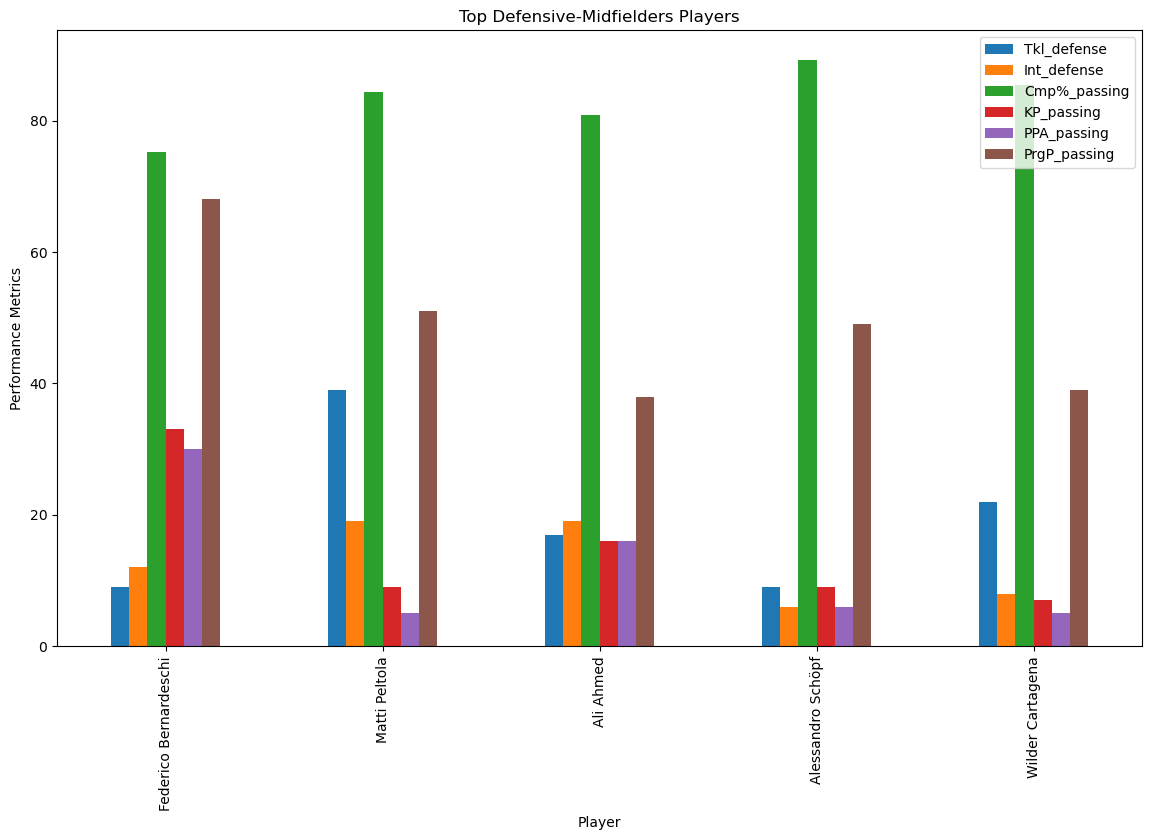

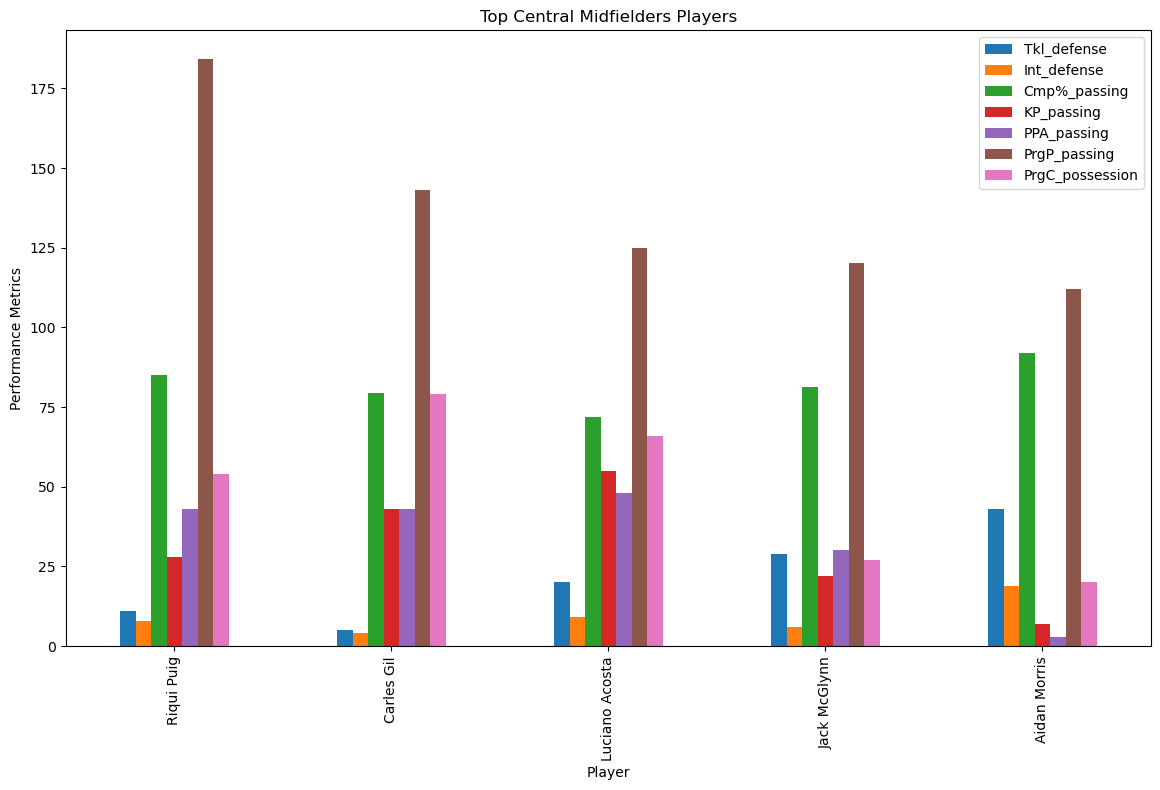

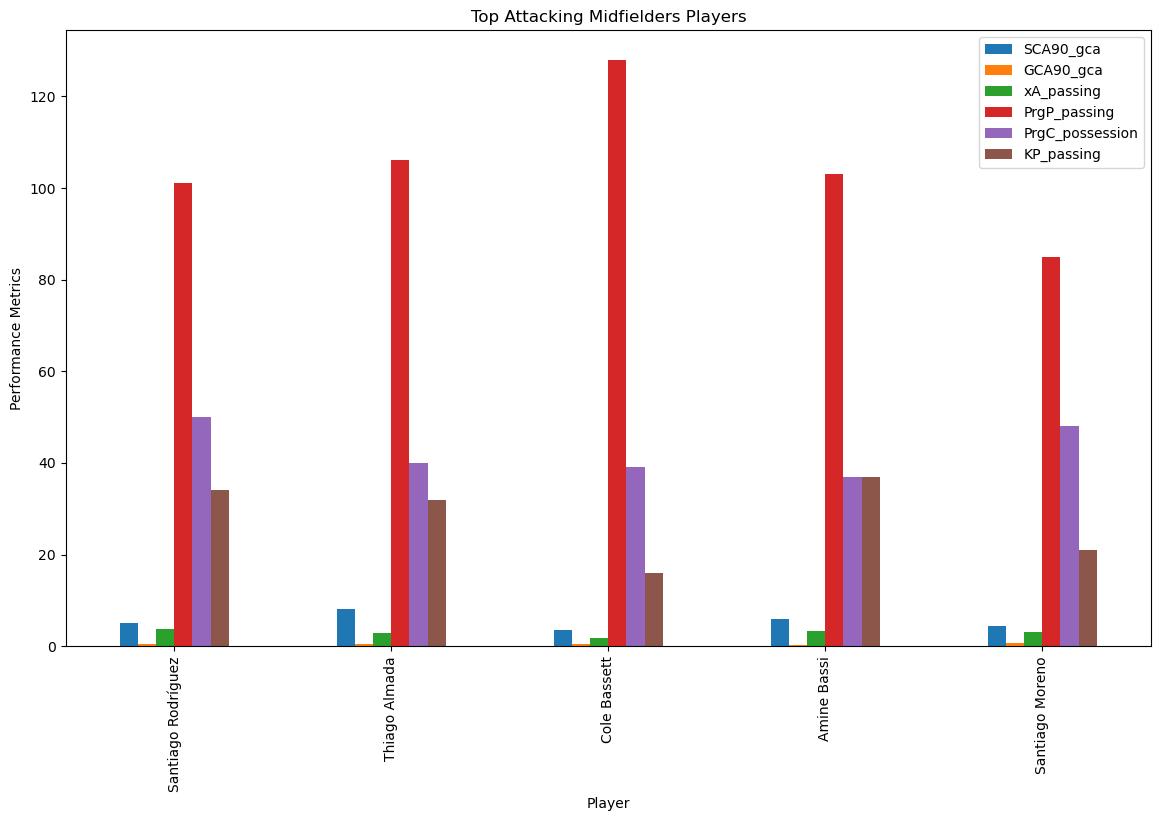

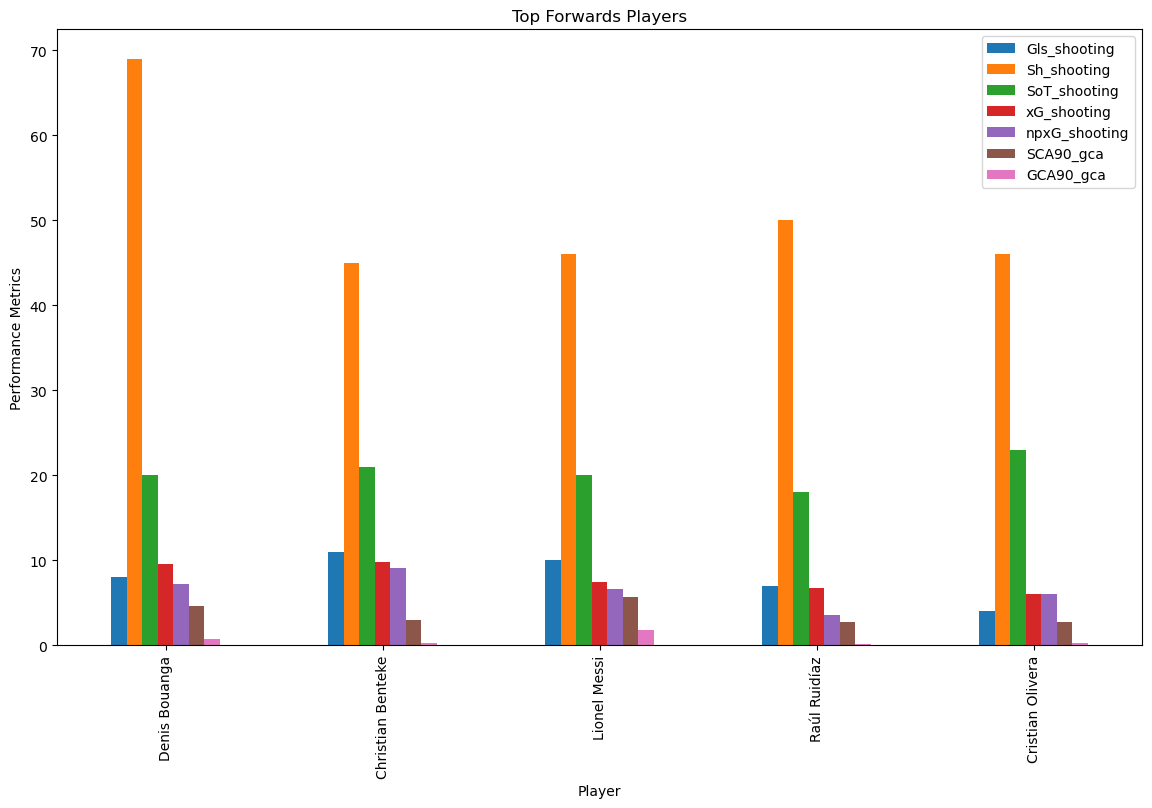

In [23]:
import matplotlib.pyplot as plt

def plot_top_players(position, players_df, key_stats):
    players_df = players_df[['Player_misc', 'Squad_misc', 'Rank'] + key_stats]
    players_df.set_index('Player_misc', inplace=True)
    players_df[key_stats].plot(kind='bar', figsize=(14, 8))
    plt.title(f'Top {position} Players')
    plt.xlabel('Player')
    plt.ylabel('Performance Metrics')
    plt.legend(loc='best')
    plt.show()

# Plot top players for each position
for position, players_df in top_players.items():
    plot_top_players(position, players_df, key_stats_columns[position])


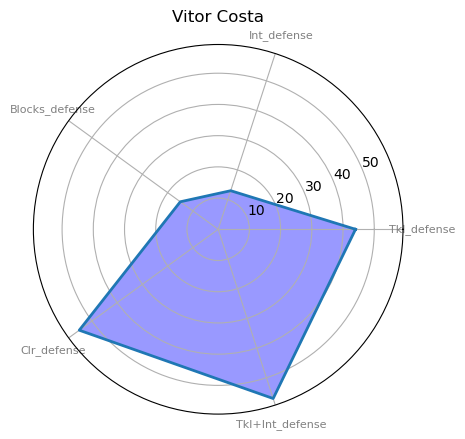

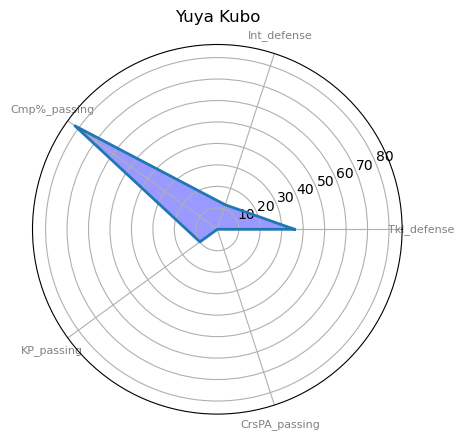

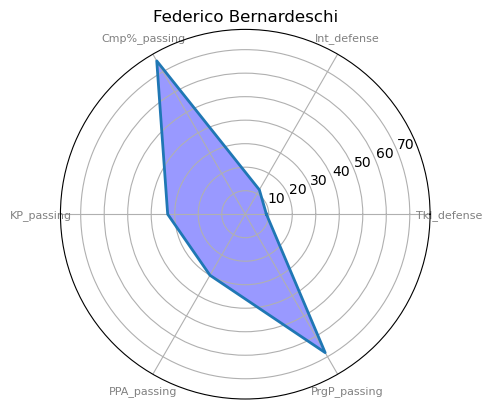

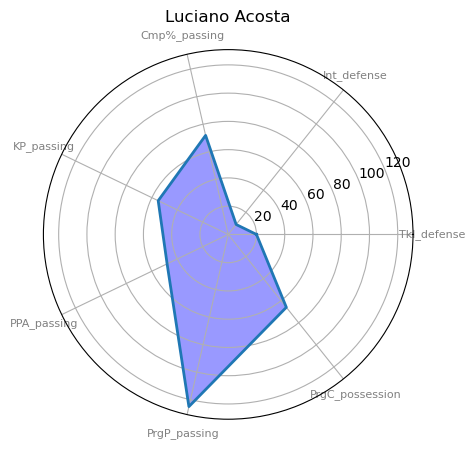

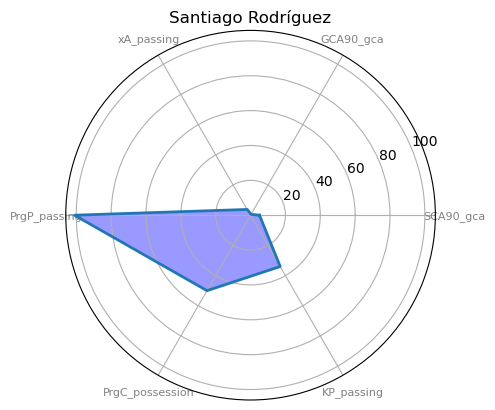

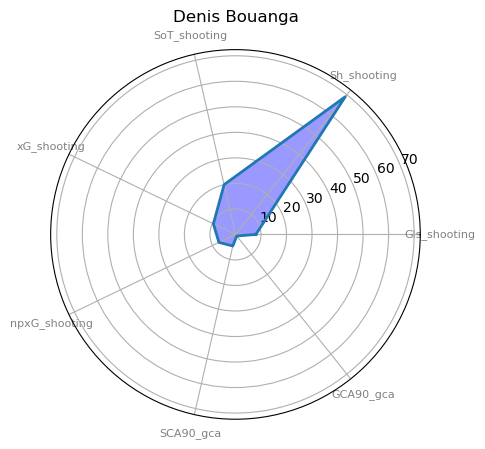

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_player_attributes(position, player_name, players_df, key_stats):
    player_data = players_df.loc[players_df['Player_misc'] == player_name, key_stats].iloc[0]
    categories = key_stats
    values = player_data.values.flatten().tolist()
    values += values[:1]  # Repeat the first value to close the circle

    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.4)

    plt.title(player_name)
    plt.show()

# Example usage for one player from each position
plot_player_attributes('Defender', 'Vitor Costa', top_players['Defender'], key_stats_columns['Defender'])
plot_player_attributes('Wing-Back', 'Yuya Kubo', top_players['Wing-Back'], key_stats_columns['Wing-Back'])
plot_player_attributes('Defensive-Midfielders', 'Federico Bernardeschi', top_players['Defensive-Midfielders'], key_stats_columns['Defensive-Midfielders'])
plot_player_attributes('Central Midfielders', 'Luciano Acosta', top_players['Central Midfielders'], key_stats_columns['Central Midfielders'])
plot_player_attributes('Attacking Midfielders', 'Santiago Rodríguez', top_players['Attacking Midfielders'], key_stats_columns['Attacking Midfielders'])
plot_player_attributes('Forwards', 'Denis Bouanga', top_players['Forwards'], key_stats_columns['Forwards'])
